In [3]:
import trainer.glue_base as glue_base
import models.sparse_token as sparse
import pickle, importlib, itertools, gc
import torch
from matplotlib import pyplot as plt
importlib.reload(glue_base)
importlib.reload(sparse)
sparse.set_update_input_mask_accumulate_indices(True)

Glue = glue_base.GlueAttentionApproxTrainer

RESULT_PKL = 'glue_benchmark_accum_absatt.pkl'
PLOT_HEADER= ''

In [4]:
subsets = ["cola","mnli","mrpc","qnli","qqp","rte","sst2","stsb","wnli",]
kss = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.625, 0.75]
#subsets = ['mrpc']
#kss = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]
#kss = [0.1, 0.5]
RUN_APPROX = False

In [ ]:
results = {}

def get_score(score):
    if 'accuracy' in score:
        return score['accuracy'], "acc"
    first_metric = list(score.keys())[0]
    return score[first_metric], first_metric

def run_exp():
    global subsets, kss

    cases = list(itertools.product(subsets, kss))
    current_subset = None
    trainer = None
    for i, (subset, ks) in enumerate(cases):
        if current_subset != subset:
            trainer = None
            gc.collect()
            torch.cuda.empty_cache()
            trainer = Glue(subset, factor=2, batch_size=8, wiki_train=False)
            if RUN_APPROX: trainer.load()
            bert_score, _ = get_score(trainer.eval_base_model())
            results[(subset, 'bert')] = { 'score_bert':bert_score }
            print('bert', bert_score)
            current_subset = subset
        
        trainer.set_batch_size(1)
        ksx = [ks for _ in range(12)]
        sparse.benchmark_reset()
        score_sparse, metric = get_score(trainer.eval_sparse_model(ks=ksx, run_original_attention=True, show_message=False))
        mask_occupy = sparse.benchmark_get_average('mask_occupy')
        print('sparse absatt', score_sparse, '@', mask_occupy)

        if RUN_APPROX:
            trainer.set_batch_size(1)
            ksx = [ks for _ in range(12)]
            sparse.benchmark_reset()
            score_approx, metric = get_score(trainer.eval_sparse_model(ks=ksx, run_original_attention=False, show_message=False))
            mask_occupy_approx = sparse.benchmark_get_average('mask_occupy')
            print('sparse approx', score_approx, '@', mask_occupy_approx)

        trainer.set_batch_size(8)
        target_ks = mask_occupy
        ksx = [target_ks*0.5+((1-x/11.0)**1.0) * target_ks for x in range(12)]
        score_forward, _ = get_score(trainer.eval_sparse_model(ks=ksx, use_forward=True, show_message=False))
        print('forward', score_forward, '@', mask_occupy)

        result = {
            'occupy':mask_occupy, 'score_sparse':score_sparse, 
            'score_forward':score_forward, 'metric':metric
        }
        if RUN_APPROX:
            result['score_sparse_approx'] = score_approx
            result['occupy_approx'] = mask_occupy_approx
        print(f"RESULT {subset}@{ks} ({i+1}/{len(cases)}) |", result)
        results[(subset, ks)] = result

    with open(RESULT_PKL, 'wb') as f:
        pickle.dump(results, f)
    
    return results
results = run_exp()

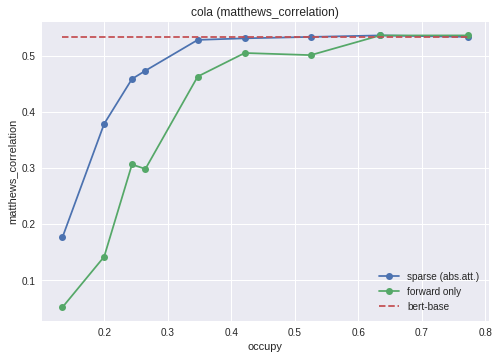

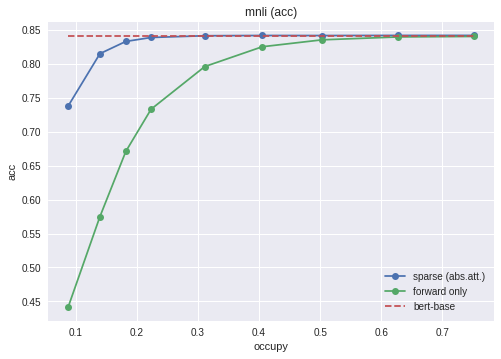

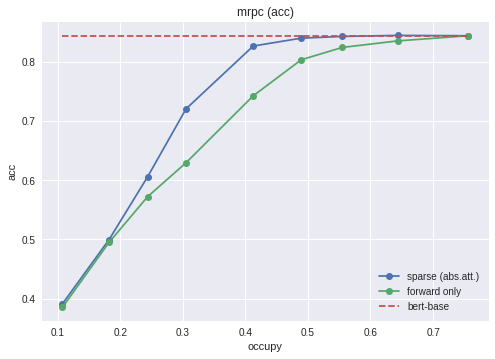

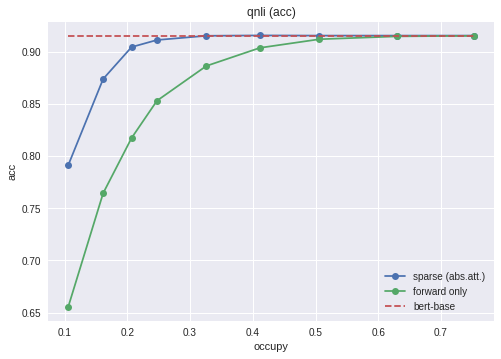

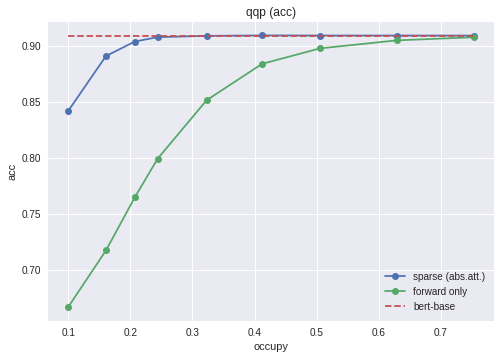

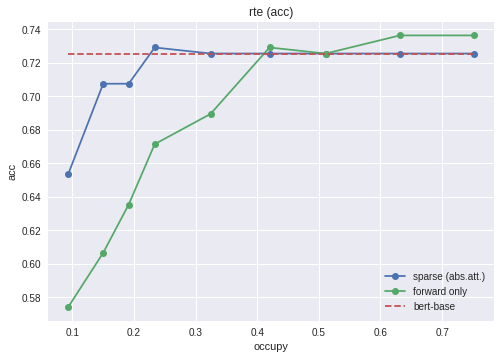

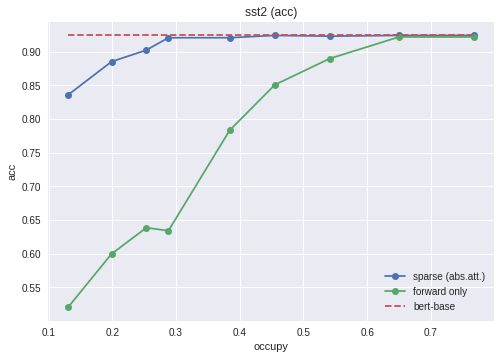

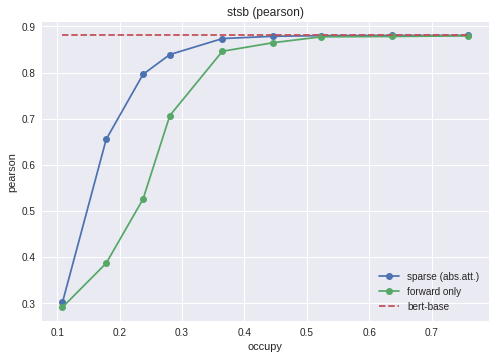

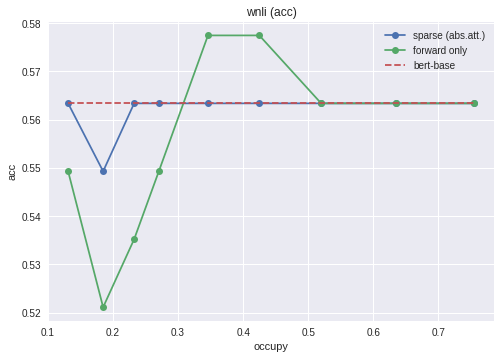

In [3]:
import pickle
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use("seaborn")

with open(RESULT_PKL, 'rb') as f:
    results = pickle.load(f)

for subset in subsets:
    acc_sparse = []
    acc_approx = []
    acc_forward = []
    occupy = []
    occupy_approx = []
    metric = None
    for ks in kss:
        item = results[(subset, ks)]
        metric = item['metric']
        acc_sparse.append(item['score_sparse'])
        if RUN_APPROX: acc_approx.append(item['score_sparse_approx'])
        acc_forward.append(item['score_forward'])
        occupy.append(item['occupy'])
        if RUN_APPROX: occupy_approx.append(item['occupy_approx'])
    acc_bert = results[(subset, 'bert')]['score_bert']
    occupy_bert = [min(occupy+occupy_approx), max(occupy+occupy_approx)]
    acc_bert = [acc_bert, acc_bert]
    plt.plot(occupy, acc_sparse, marker='o', label='sparse (abs.att.)')
    if RUN_APPROX: plt.plot(occupy_approx, acc_approx, marker='o', label='sparse (approx.)')
    plt.plot(occupy, acc_forward, marker='o', label='forward only')
    plt.plot(occupy_bert, acc_bert, linestyle='--', label='bert-base')
    plt.xlabel('occupy')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'{subset} ({metric})')
    plt.savefig(f'saves_plot/{PLOT_HEADER}accum_absolute_attention_{subset}.png', dpi=320)
    plt.show(block=False)